In [1]:
library(dplyr)
library(stringr)
library(Seurat) 
library(ggplot2)
library(RColorBrewer)
library(viridis)
library(ggrepel)
library(reshape2)
library(stringdist)
library(ggbeeswarm)
library(ggpubr)
library(shazam)
library(alakazam)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

‘SeuratObject’ was built with package ‘Matrix’ 1.6.3 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


Loading required package: viridisLite

Warning message:
“package ‘stringdist’ was built under R version 4.3.3”


To cite the SHazaM package in publications, please use:

  Gupta N, Vander Heiden J, Uduman M, Gadala-Maria D, Yaari G,
  Kleinstein S (2015). “Change-O: a toolkit for ana

In [2]:
my.comparison = list(c('Alum-pSer','SMNP'),c('SMNP','Alum-pSer/SMNP'),
                     c('Alum-pSer','Alum-pSer/SMNP'))
group.col=c('Alum-pSer'='#0072B2','SMNP'='#E69F00','Alum-pSer/SMNP'='#009E73')
col=ggthemes::ggthemes_data[["tableau"]][["color-palettes"]][["regular"]]$`Classic 10`$value
col=rev(col[1:7])
cluster.col = c(col[1:3],col[5],col[4],col[7],col[6])
names(cluster.col) = paste0('C',rep(1:7))
Axis_themes <- theme(plot.title = element_text(size = 8,hjust=0.5),
                     axis.title = element_text(size = 8),
                     axis.text = element_text(size = 8,color='black'),
                     axis.text.x = element_text(size = 8,angle=45,hjust=1),                     
                     legend.text = element_text(size = 8),
                     legend.title = element_text(size = 8),
                     legend.key.size = unit(.3, 'cm'),
                     strip.text.x = element_text(size = 8),
                     strip.background = element_rect(fill=NA,linewidth=0.5,color='black'),
                     axis.line = element_line(linewidth = .3),
                     axis.ticks = element_line(linewidth = 0.3))

In [3]:
srat = readRDS('seurat_object/01_harmony_labeled.RDS')
srat$group = factor(srat$group, levels=c('Alum-pSer','SMNP','Alum-pSer/SMNP'))
srat

An object of class Seurat 
26779 features across 19537 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, harmony, umap

In [4]:
hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc)
lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(lc)

[1] 4637   95

[1] 8715   86

In [5]:
metadata = srat@meta.data

hc.match = hc %>% filter(hc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(GERMLINE_V_CALL,',',1))
dim(hc)

lc.match = lc %>% filter(lc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGL_V_CALL = str_split_i(V_CALL,',',1))
dim(lc)

metadata$IGH_recovery = as.numeric(metadata$cell_id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$cell_id %in% lc$LANE_ID)
metadata$recovery = metadata$IGH_recovery + metadata$IGL_recovery

# recovery info
srat$recovery = metadata$recovery[match(srat$cell_id, metadata$cell_id)]

# heavy chain info
srat$IGH_GERMLINE_V_CALL = hc.match$IGH_GERMLINE_V_CALL[match(srat$cell_id, hc.match$LANE_ID)]
srat$CLONE = hc.match$CLONE[match(srat$cell_id, hc.match$LANE_ID)]
# light chain info
srat$IGL_V_CALL = lc.match$IGL_V_CALL[match(srat$cell_id, lc.match$LANE_ID)]


[1] 4637   95

[1] 8715   86

In [6]:
colnames(srat@meta.data)

[1] "orig.ident"                "nCount_RNA"               
 [3] "nFeature_RNA"              "cell_id"                  
 [5] "nCount_HTO"                "nFeature_HTO"             
 [7] "HTO_maxID"                 "HTO_secondID"             
 [9] "HTO_margin"                "HTO_classification"       
[11] "HTO_classification.global" "hash.ID"                  
[13] "percent.mt"                "batch"                    
[15] "RNA_snn_res.0.1"           "RNA_snn_res.0.3"          
[17] "RNA_snn_res.0.5"           "seurat_clusters"          
[19] "group"                     "mouse.id"                 
[21] "UMAP1"                     "UMAP2"                    
[23] "RNA_snn_res.0.4"           "RNA_snn_res.0.6"          
[25] "RNA_snn_res.0.7"           "RNA_snn_res.0.8"          
[27] "RNA_snn_res.0.9"           "RNA_snn_res.1.1"          
[29] "phenocluster"              "recovery"                 
[31] "IGH_GERMLINE_V_CALL"       "CLONE"                    
[33] "IGL_V_CALL"

`summarise()` has grouped output by 'Group', 'Mouse', 'clone.type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id', 'phenocluster'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id'. You can override using the
`.groups` argument.


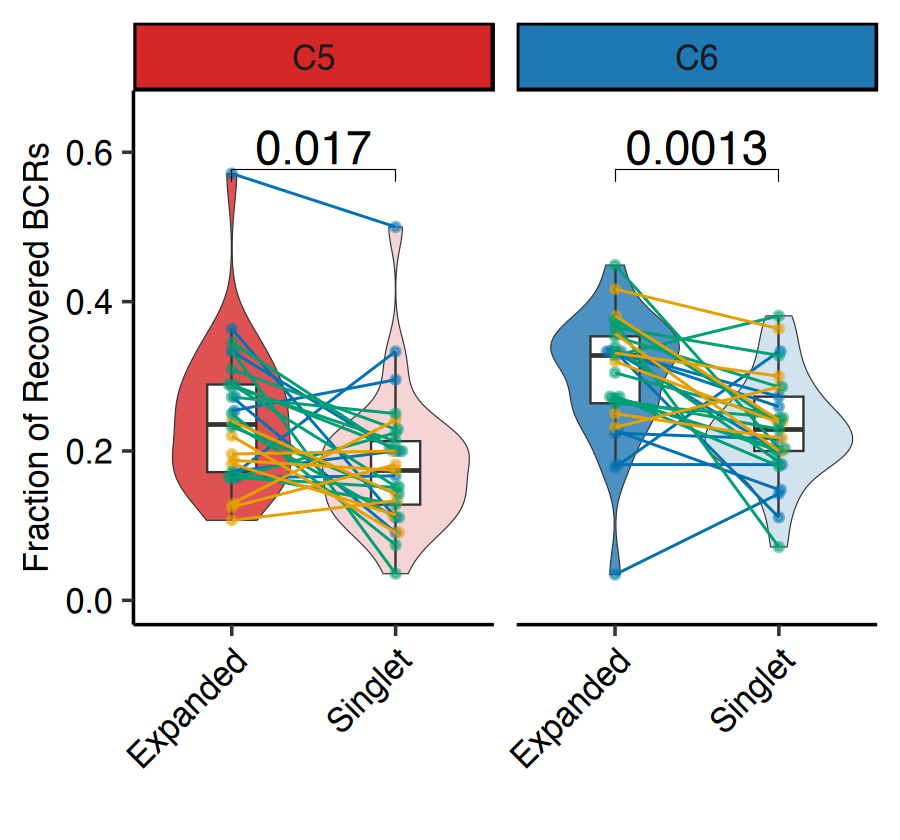

In [11]:
options(repr.plot.height=2.8, repr.plot.width=3, repr.plot.res=300)
metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')
count <- countClones(metadata, clone = 'CLONE')
metadata$clonal.size <- count$seq_count[match(metadata$CLONE, count$CLONE)]
metadata = metadata %>% mutate(clone.type = ifelse(clonal.size>1,'Expanded','Singlet'))

# calculate fraction 
df4gg = metadata %>% group_by(Group,Mouse,clone.type,phenocluster)  %>%
summarise(ncell.clus.type=n()) %>% 
mutate(ncell.type=sum(ncell.clus.type),frac=ncell.clus.type/ncell.type,mouse.id = paste(Group,Mouse,phenocluster)) 

# add ncell.mouse info
ncell.mouse= metadata %>% count(Group,Mouse,name = 'ncell')
ncell.mouse = ncell.mouse %>% filter(Mouse %in% df4gg$Mouse)
df4gg$ncell = ncell.mouse$ncell[match(df4gg$Mouse,ncell.mouse$Mouse)]

# only keep mouse that have both expanded and singlets 
mouse2keep = df4gg %>%  ungroup() %>% filter(ncell>10) %>%
group_by(mouse.id,phenocluster,clone.type) %>% summarise(ntype=n()) %>%
summarise(ntype=sum(ntype)) %>% filter(ntype>1)

# adjust color
df4gg = df4gg %>% filter(mouse.id %in% mouse2keep$mouse.id, phenocluster !='C1') %>% 
mutate(clus.type=paste(phenocluster,clone.type,sep='_'))
df4gg$fill.col=cluster.col[match(df4gg$phenocluster,names(cluster.col))]
df4gg = df4gg %>% mutate(fill.col = ifelse(clone.type=='Singlet',alpha(fill.col,0.2),alpha(fill.col,0.8)))
names(df4gg$fill.col) = df4gg$clus.type

strip = ggh4x::strip_themed(background_x = ggh4x::elem_list_rect(fill = cluster.col[5:6]))

df4gg = df4gg %>% filter(phenocluster%in%c('C5','C6')) 
df4gg %>% 
ggplot(aes(x=clone.type,y=frac)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=clus.type),size=0.1)+
geom_boxplot(fill='white',outlier.shape=NA,size=0.2,width=0.3) + 
geom_beeswarm(aes(color=Group),size=0.5,alpha=0.5) + 
geom_line(aes(group= mouse.id,color=Group),linewidth=0.25) +
ylim(0,0.65)+
stat_compare_means(method='t.test',comparisons=list(c('Expanded','Singlet')),label.y=0.55,
                   bracket.size = 0.1) +
ggh4x::facet_wrap2('phenocluster',strip = strip, nrow = 1) + 
labs(x='',y='Fraction of Recovered BCRs') +
scale_color_manual(values=group.col) +
scale_fill_manual(values=df4gg$fill.col) + 
Axis_themes

out = 'figures/fig3/expanded_vs_singlet.pdf'
ggsave(out,device='pdf', height = 2.8, width = 3,
       dpi = 300,useDingbats = FALSE)


In [45]:
for (clus in sort(unique(df4gg$phenocluster))) {
    test = df4gg %>% filter(phenocluster==clus) %>% ungroup() %>% select(Group, Mouse,clone.type, frac)
    test = test %>% tidyr::pivot_wider(names_from = clone.type, values_from = frac )
    res = wilcox.test(test$Expanded, test$Singlet, paired = TRUE)
    print(clus)
    print(res)
}

[1] "C5"

	Wilcoxon signed rank exact test

data:  test$Expanded and test$Singlet
V = 346, p-value = 0.004436
alternative hypothesis: true location shift is not equal to 0



Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with zeroes”


[1] "C6"

	Wilcoxon signed rank test with continuity correction

data:  test$Expanded and test$Singlet
V = 346, p-value = 0.001175
alternative hypothesis: true location shift is not equal to 0



`summarise()` has grouped output by 'Group', 'Mouse', 'clone.type'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id', 'phenocluster'. You can
override using the `.groups` argument.
`summarise()` has grouped output by 'mouse.id'. You can override using the
`.groups` argument.


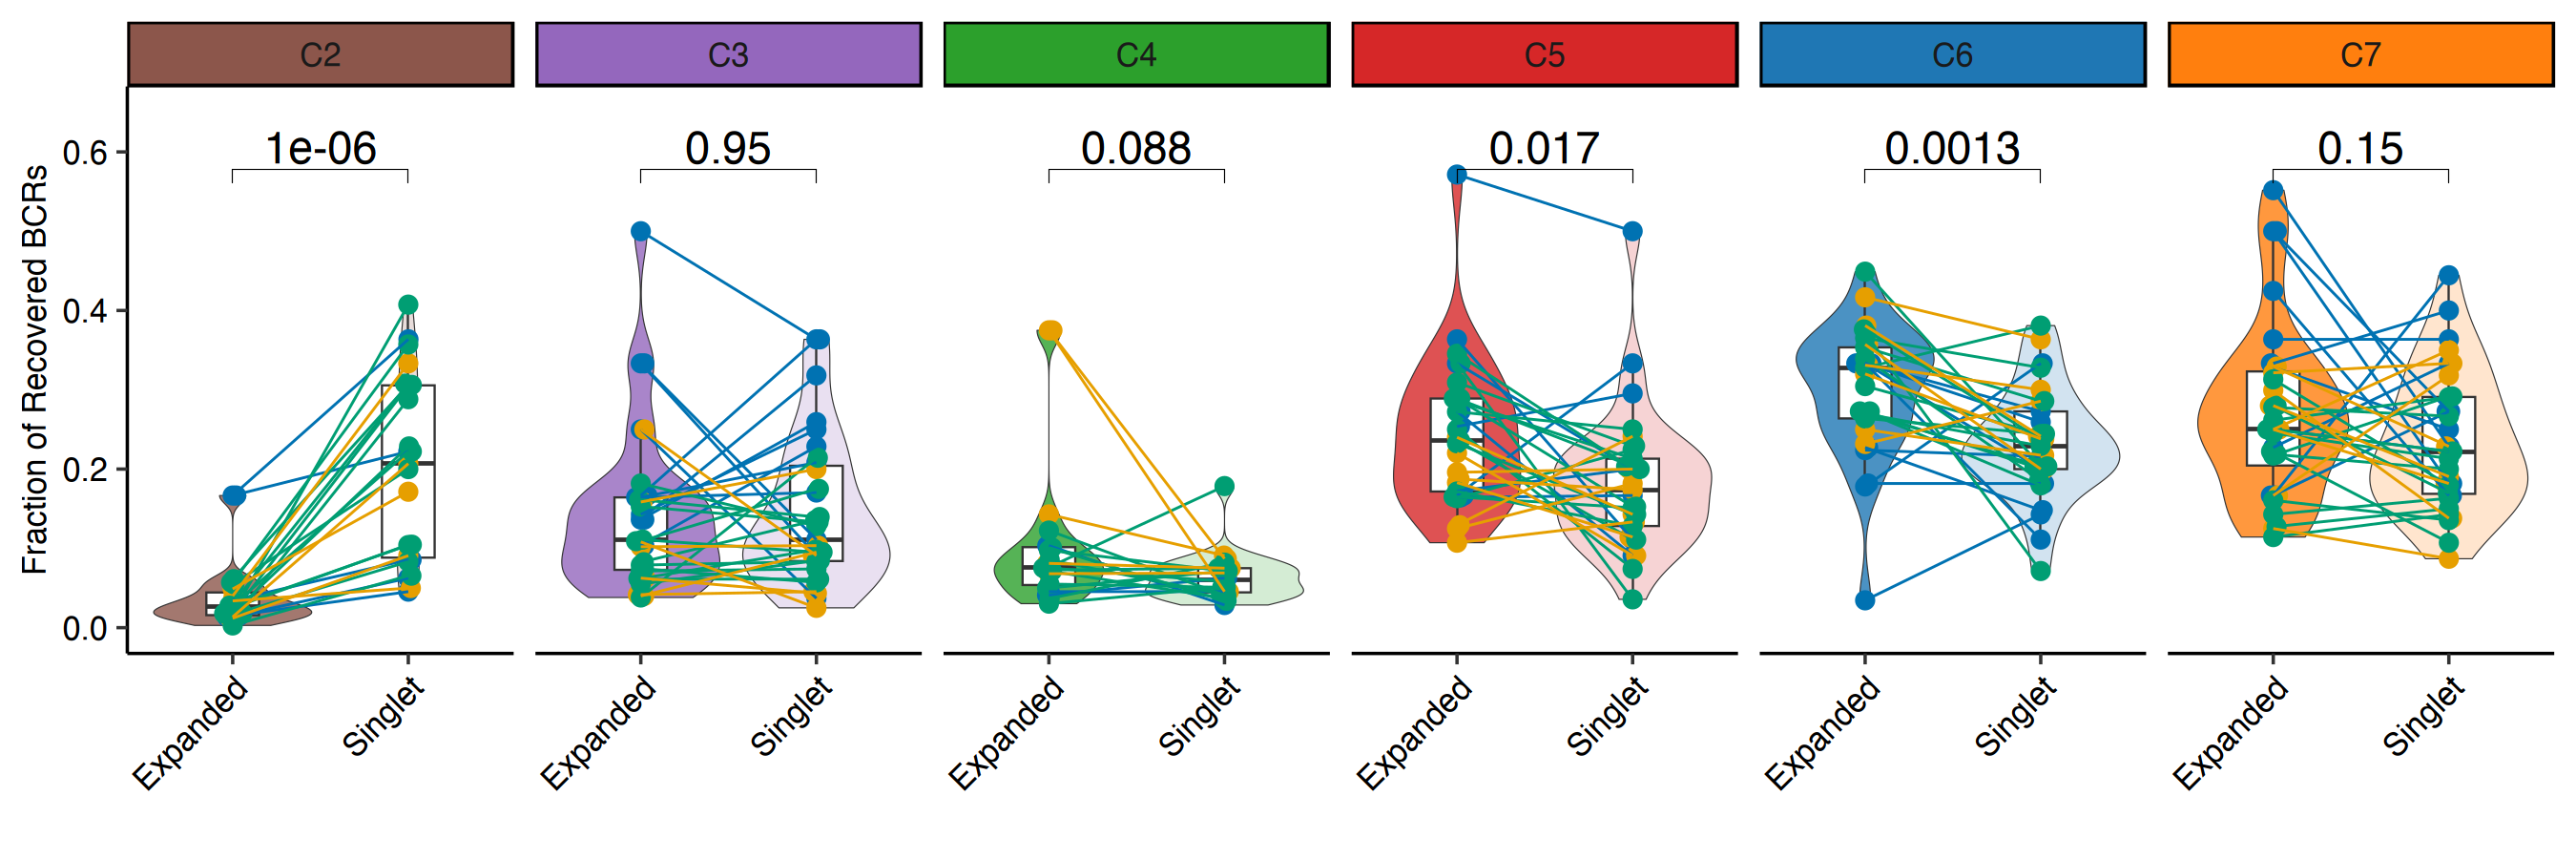

In [37]:
options(repr.plot.height=3, repr.plot.width=9, repr.plot.res=300)
metadata = srat@meta.data %>% filter(CLONE>0) %>% rename('Mouse' = 'mouse.id','Group'='group')
count <- countClones(metadata, clone = 'CLONE')
metadata$clonal.size <- count$seq_count[match(metadata$CLONE, count$CLONE)]
metadata = metadata %>% mutate(clone.type = ifelse(clonal.size>1,'Expanded','Singlet'))

# calculate fraction 
df4gg = metadata %>% group_by(Group,Mouse,clone.type,phenocluster)  %>%
summarise(ncell.clus.type=n()) %>% 
mutate(ncell.type=sum(ncell.clus.type),frac=ncell.clus.type/ncell.type,mouse.id = paste(Group,Mouse,phenocluster)) 

# add ncell.mouse info
ncell.mouse= metadata %>% count(Group,Mouse,name = 'ncell')
ncell.mouse = ncell.mouse %>% filter(Mouse %in% df4gg$Mouse)
df4gg$ncell = ncell.mouse$ncell[match(df4gg$Mouse,ncell.mouse$Mouse)]

# only keep mouse that have both expanded and singlets 
mouse2keep = df4gg %>%  ungroup() %>% filter(ncell>10) %>%
group_by(mouse.id,phenocluster,clone.type) %>% summarise(ntype=n()) %>%
summarise(ntype=sum(ntype)) %>% filter(ntype>1)

# adjust color
df4gg = df4gg %>% filter(mouse.id %in% mouse2keep$mouse.id, phenocluster !='C1') %>% 
mutate(clus.type=paste(phenocluster,clone.type,sep='_'))
df4gg$fill.col=col[match(df4gg$phenocluster,names(cluster.col))]
df4gg = df4gg %>% mutate(fill.col = ifelse(clone.type=='Singlet',alpha(fill.col,0.2),alpha(fill.col,0.8)))
names(df4gg$fill.col) = df4gg$clus.type

strip = ggh4x::strip_themed(background_x = ggh4x::elem_list_rect(fill = cluster.col[2:7]))

df4gg %>% 
ggplot(aes(x=clone.type,y=frac)) + theme_classic() + NoLegend()+
geom_violin(aes(fill=clus.type),size=0.1)+
geom_boxplot(fill='white',outlier.shape=NA,size=0.2,width=0.3) + 
geom_beeswarm(aes(color=Group)) + 
geom_line(aes(group= mouse.id,color=Group),linewidth=0.25) +
ylim(0,0.65)+
stat_compare_means(method='t.test',comparisons=list(c('Expanded','Singlet')),label.y=0.55,
                   bracket.size = 0.1) +
ggh4x::facet_wrap2('phenocluster',strip = strip, nrow = 1) + 
labs(x='',y='Fraction of Recovered BCRs') +
scale_color_manual(values=group.col) +
scale_fill_manual(values=df4gg$fill.col) + 
Axis_themes

# out = 'md39/figures/fig3/expanded_vs_singlet2.pdf'
# ggsave(out,device='pdf', height = 10, width = 5,
#        dpi = 300,useDingbats = FALSE)


In [40]:
for (clus in sort(unique(df4gg$phenocluster))) {
    test = df4gg %>% filter(phenocluster==clus) %>% ungroup() %>% select(Group, Mouse,clone.type, frac)
    test = test %>% tidyr::pivot_wider(names_from = clone.type, values_from = frac )
    res = wilcox.test(test$Expanded, test$Singlet, paired = TRUE)
    print(clus)
    print(res)
}

[1] "C2"

	Wilcoxon signed rank exact test

data:  test$Expanded and test$Singlet
V = 0, p-value = 2.384e-07
alternative hypothesis: true location shift is not equal to 0



Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with zeroes”


[1] "C3"

	Wilcoxon signed rank test with continuity correction

data:  test$Expanded and test$Singlet
V = 209, p-value = 0.6362
alternative hypothesis: true location shift is not equal to 0



Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with zeroes”


[1] "C4"

	Wilcoxon signed rank test with continuity correction

data:  test$Expanded and test$Singlet
V = 137, p-value = 0.09491
alternative hypothesis: true location shift is not equal to 0

[1] "C5"

	Wilcoxon signed rank exact test

data:  test$Expanded and test$Singlet
V = 346, p-value = 0.004436
alternative hypothesis: true location shift is not equal to 0



Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with zeroes”


[1] "C6"

	Wilcoxon signed rank test with continuity correction

data:  test$Expanded and test$Singlet
V = 346, p-value = 0.001175
alternative hypothesis: true location shift is not equal to 0



Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(test$Expanded, test$Singlet, paired = TRUE):
“cannot compute exact p-value with zeroes”


[1] "C7"

	Wilcoxon signed rank test with continuity correction

data:  test$Expanded and test$Singlet
V = 325, p-value = 0.1338
alternative hypothesis: true location shift is not equal to 0



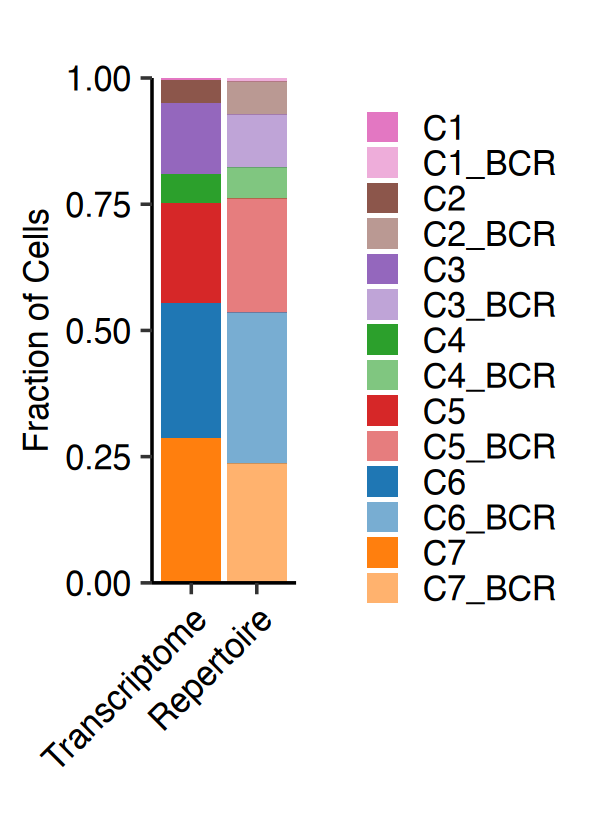

In [14]:
options(repr.plot.height=2.8,repr.plot.width=2,repr.plot.res=300)

metadata1 = srat@meta.data %>%  mutate(data='Transcriptome') 
metadata2 = srat@meta.data %>% filter(CLONE > 0) %>% 
mutate(data='Repertoire',phenocluster=paste(phenocluster,'BCR',sep='_'))
metadata2$phenocluster = factor(metadata2$phenocluster, levels=c('C1_BCR','C2_BCR','C3_BCR','C4_BCR','C5_BCR','C6_BCR','C7_BCR'))

cluster.col2 = alpha(cluster.col,0.6)
names(cluster.col2) = c('C1_BCR','C2_BCR','C3_BCR','C4_BCR','C5_BCR','C6_BCR','C7_BCR')

df4gg = rbind(metadata1,metadata2)

df4gg %>% 
ggplot(aes(x=factor(data, levels=c('Transcriptome','Repertoire')),fill=phenocluster)) + 
theme_classic()+
geom_bar(position='fill')+
scale_fill_manual(values=c(cluster.col,cluster.col2 )) + 
labs(x='',y='Fraction of Cells',title='',fill='')+
scale_y_continuous(expand=c(0,0)) +
Axis_themes

out = 'figures/fig3/cluster_distribution_BCR_vs_Transcriptome.pdf'
ggsave(out,device='pdf', height = 2.8, width = 2,
       dpi = 300,useDingbats = FALSE)


In [50]:
a = df4gg %>% group_by(data,phenocluster) %>% summarise(ncell.clus=n()) 
df1 = a %>% filter(data == 'Repertoire')
df2 = a %>% filter(data == 'Transcriptome')
chisq.test(x=df1$ncell.clus, y=df2$ncell.clus)

`summarise()` has grouped output by 'data'. You can override using the
`.groups` argument.
Warning message in chisq.test(x = df1$ncell.clus, y = df2$ncell.clus):
“Chi-squared approximation may be incorrect”



	Pearson's Chi-squared test

data:  df1$ncell.clus and df2$ncell.clus
X-squared = 42, df = 36, p-value = 0.227


In [ ]:
### Compile for GEO submission ###

In [14]:
srat = readRDS('seurat_object/01_harmony_labeled.RDS')
srat$group = factor(srat$group, levels=c('Alum-pSer','SMNP','Alum-pSer/SMNP'))
srat

An object of class Seurat 
26779 features across 19537 samples within 2 assays 
Active assay: RNA (26769 features, 2000 variable features)
 3 layers present: data, counts, scale.data
 1 other assay present: HTO
 3 dimensional reductions calculated: pca, harmony, umap

In [42]:
hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc)

hc.meta = read.table('bcr_output/05_hc_meta_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(hc.meta)

lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') 
dim(lc)

[1] 4637   95

[1] 4637   95

[1] 8715   86

In [17]:
# add SHM
hc = hc %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',
                       germlineColumn = 'GERMLINE_SEQUENCE_D_MASK', 
                       frequency = FALSE,combine=TRUE) 

lc = lc %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',
                       germlineColumn = 'GERMLINE_IMGT', 
                       frequency = FALSE,combine=TRUE) 


In [20]:
metadata = srat@meta.data

hc.match = hc %>% filter(hc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(GERMLINE_V_CALL,',',1)) 

hc.meta.match = hc.meta %>% filter(hc.meta$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGH_GERMLINE_V_CALL = str_split_i(GERMLINE_V_CALL,',',1)) 

lc.match = lc %>% filter(lc$LANE_ID %in% metadata$cell_id) %>% 
mutate(IGL_V_CALL = str_split_i(V_CALL,',',1))

# recovery info 
metadata$IGH_recovery = as.numeric(metadata$cell_id %in% hc$LANE_ID) * 2
metadata$IGL_recovery = as.numeric(metadata$cell_id %in% lc$LANE_ID)
metadata$recovery = metadata$IGH_recovery + metadata$IGL_recovery

# add heavy chain info to metadata 
a = hc.match[c('LANE_ID','ISOTYPE','CDR3NUC','CDR3',
               'CLONE','GERMLINE_V_CALL','mu_count')] 
colnames(a)<-paste('IGH',colnames(a),sep="_")
metadata = merge(metadata, a,by.x='cell_id', by.y='IGH_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$cell_id
metadata = metadata %>% dplyr::rename('CLONE'='IGH_CLONE')

# add light chain info to metadata 
b = lc.match[c('LANE_ID','ISOTYPE','CDR3nuc','CDR3','V_CALL','mu_count')]
colnames(b)<-paste('IGL',colnames(b),sep="_")
b = b %>% mutate(IGL_V_CALL = str_split_i(IGL_V_CALL,',',1))
metadata = merge(metadata, b,by.x='cell_id', by.y='IGL_LANE_ID', all.x=TRUE)
rownames(metadata)= metadata$cell_id

srat@meta.data = metadata 
srat$META_CLONE = hc.meta.match$CLONE[match(srat$cell_id, hc.meta.match$LANE_ID)]


In [24]:
geo.srat = srat
geo.srat@meta.data = geo.srat@meta.data %>% 
        select(-c(nFeature_HTO, HTO_secondID,HTO_maxID,HTO_margin,seurat_clusters,
                  hash.ID, RNA_snn_res.1.1,
                  RNA_snn_res.0.1,RNA_snn_res.0.3,RNA_snn_res.0.4,RNA_snn_res.0.5,
                  RNA_snn_res.0.6,RNA_snn_res.0.7,RNA_snn_res.0.8,RNA_snn_res.0.9))
colnames(geo.srat@meta.data)
head(geo.srat@meta.data)

[1] "cell_id"                   "orig.ident"               
 [3] "nCount_RNA"                "nFeature_RNA"             
 [5] "nCount_HTO"                "HTO_classification"       
 [7] "HTO_classification.global" "percent.mt"               
 [9] "batch"                     "group"                    
[11] "mouse.id"                  "UMAP1"                    
[13] "UMAP2"                     "phenocluster"             
[15] "IGH_recovery"              "IGL_recovery"             
[17] "recovery"                  "IGH_ISOTYPE"              
[19] "IGH_CDR3NUC"               "IGH_CDR3"                 
[21] "CLONE"                     "IGH_GERMLINE_V_CALL"      
[23] "IGH_mu_count"              "IGL_ISOTYPE"              
[25] "IGL_CDR3nuc"               "IGL_CDR3"                 
[27] "IGL_V_CALL"                "IGL_mu_count"             
[29] "META_CLONE"

,cell_id,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,HTO_classification,HTO_classification.global,percent.mt,batch,group,⋯,IGH_CDR3,CLONE,IGH_GERMLINE_V_CALL,IGH_mu_count,IGL_ISOTYPE,IGL_CDR3nuc,IGL_CDR3,IGL_V_CALL,IGL_mu_count,META_CLONE
,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<fct>,⋯,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
AG1_AAAATTATCATT,AG1_AAAATTATCATT,AG1,1332,422,310,HTO3.CTTGCCGCATGTCAT,Singlet,10.210210,AG,SMNP,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_GGGTGGCGCGTA,AG1_GGGTGGCGCGTA,AG1,1918,341,39,HTO2.GGTCGAGAGCATTCA,Singlet,3.180396,AG,SMNP,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_TGTCCCGAGGGA,AG1_TGTCCCGAGGGA,AG1,4700,1264,407,HTO2.GGTCGAGAGCATTCA,Singlet,6.212766,AG,SMNP,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_TTGTTAGTCCTA,AG1_TTGTTAGTCCTA,AG1,4188,1012,195,HTO2.GGTCGAGAGCATTCA,Singlet,8.834766,AG,SMNP,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG2_ACCCCACTTCTA,AG2_ACCCCACTTCTA,AG2,1841,367,119,HTO2.GGTCGAGAGCATTCA,Singlet,3.422053,AG,Alum-pSer,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG2_ACTGGGTTGTAA,AG2_ACTGGGTTGTAA,AG2,8000,1361,390,HTO2.GGTCGAGAGCATTCA,Singlet,6.412500,AG,Alum-pSer,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [22]:
colnames(geo.srat@meta.data)
head(geo.srat@meta.data)

[1] "cell_id"                   "orig.ident"               
 [3] "nCount_RNA"                "nFeature_RNA"             
 [5] "nCount_HTO"                "nFeature_HTO"             
 [7] "HTO_classification"        "HTO_classification.global"
 [9] "hash.ID"                   "percent.mt"               
[11] "batch"                     "group"                    
[13] "mouse.id"                  "UMAP1"                    
[15] "UMAP2"                     "phenocluster"             
[17] "IGH_recovery"              "IGL_recovery"             
[19] "recovery"                  "IGH_ISOTYPE"              
[21] "IGH_CDR3NUC"               "IGH_CDR3"                 
[23] "CLONE"                     "IGH_GERMLINE_V_CALL"      
[25] "IGH_mu_count"              "IGL_ISOTYPE"              
[27] "IGL_CDR3nuc"               "IGL_CDR3"                 
[29] "IGL_V_CALL"                "IGL_mu_count"             
[31] "META_CLONE"

,cell_id,orig.ident,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,HTO_classification,HTO_classification.global,hash.ID,percent.mt,⋯,IGH_CDR3,CLONE,IGH_GERMLINE_V_CALL,IGH_mu_count,IGL_ISOTYPE,IGL_CDR3nuc,IGL_CDR3,IGL_V_CALL,IGL_mu_count,META_CLONE
,<chr>,<chr>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>
AG1_AAAATTATCATT,AG1_AAAATTATCATT,AG1,1332,422,310,4,HTO3.CTTGCCGCATGTCAT,Singlet,HTO3.CTTGCCGCATGTCAT,10.210210,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_GGGTGGCGCGTA,AG1_GGGTGGCGCGTA,AG1,1918,341,39,4,HTO2.GGTCGAGAGCATTCA,Singlet,HTO2.GGTCGAGAGCATTCA,3.180396,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_TGTCCCGAGGGA,AG1_TGTCCCGAGGGA,AG1,4700,1264,407,4,HTO2.GGTCGAGAGCATTCA,Singlet,HTO2.GGTCGAGAGCATTCA,6.212766,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG1_TTGTTAGTCCTA,AG1_TTGTTAGTCCTA,AG1,4188,1012,195,4,HTO2.GGTCGAGAGCATTCA,Singlet,HTO2.GGTCGAGAGCATTCA,8.834766,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG2_ACCCCACTTCTA,AG2_ACCCCACTTCTA,AG2,1841,367,119,4,HTO2.GGTCGAGAGCATTCA,Singlet,HTO2.GGTCGAGAGCATTCA,3.422053,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
AG2_ACTGGGTTGTAA,AG2_ACTGGGTTGTAA,AG2,8000,1361,390,4,HTO2.GGTCGAGAGCATTCA,Singlet,HTO2.GGTCGAGAGCATTCA,6.412500,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [25]:
saveRDS(geo.srat,'seurat_object/MD39_GCB_Final.RDS')

In [ ]:
# bcr_contig.csv files 

In [78]:
hc = read.table('bcr_output/05_hc_private_clones_germ-pass.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',
                       germlineColumn = 'GERMLINE_SEQUENCE_D_MASK', 
                       frequency = FALSE,combine=TRUE) 
dim(hc)

lc = read.table('bcr_output/03_lc_translated.tab',
                stringsAsFactors = FALSE, header = TRUE, sep = '\t') %>% 
     observedMutations(sequenceColumn = 'CONSENSUS_SEQUENCE',
                       germlineColumn = 'GERMLINE_IMGT', 
                       frequency = FALSE,combine=TRUE) 
dim(lc)

[1] 4637   96

[1] 8715   87

In [79]:
# need to fix a few columns 
prior.hc = read.table('bcr_output/04_hc_pre_defineclones.tab',stringsAsFactors = FALSE, header = TRUE, sep = '\t')
hc$FUNCTIONAL = prior.hc$FUNCTIONAL[match(hc$SEQUENCE_ID, prior.hc$SEQUENCE_ID)]
hc$IN_FRAME = prior.hc$IN_FRAME[match(hc$SEQUENCE_ID, prior.hc$SEQUENCE_ID)]
hc$STOP = prior.hc$STOP[match(hc$SEQUENCE_ID, prior.hc$SEQUENCE_ID)]
hc$INDELS = prior.hc$INDELS[match(hc$SEQUENCE_ID, prior.hc$SEQUENCE_ID)]


In [81]:
# Capitalize all column names
lc = lc %>% select(-Sample)
colnames(hc) <- toupper(colnames(hc))
colnames(lc) <- toupper(colnames(lc))

df = merge(hc, lc, by='LANE_ID', all = TRUE,suffixes = c(".IGH",".IGL")) %>% 
filter(LANE_ID %in% geo.srat$cell_id)
colnames(df)

[1] "LANE_ID"                  "SEQUENCE_ID.IGH"         
  [3] "SEQUENCE_INPUT.IGH"       "FUNCTIONAL.IGH"          
  [5] "IN_FRAME.IGH"             "STOP.IGH"                
  [7] "MUTATED_INVARIANT.IGH"    "INDELS.IGH"              
  [9] "LOCUS.IGH"                "V_CALL.IGH"              
 [11] "D_CALL.IGH"               "J_CALL.IGH"              
 [13] "SEQUENCE_VDJ.IGH"         "SEQUENCE_IMGT.IGH"       
 [15] "V_SEQ_START.IGH"          "V_SEQ_LENGTH.IGH"        
 [17] "V_GERM_START_VDJ.IGH"     "V_GERM_LENGTH_VDJ.IGH"   
 [19] "V_GERM_START_IMGT.IGH"    "V_GERM_LENGTH_IMGT.IGH"  
 [21] "NP1_LENGTH.IGH"           "D_SEQ_START.IGH"         
 [23] "D_SEQ_LENGTH.IGH"         "D_GERM_START.IGH"        
 [25] "D_GERM_LENGTH.IGH"        "NP2_LENGTH.IGH"          
 [27] "J_SEQ_START.IGH"          "J_SEQ_LENGTH.IGH"        
 [29] "J_GERM_START.IGH"         "J_GERM_LENGTH.IGH"       
 [31] "JUNCTION.IGH"             "JUNCTION_LENGTH.IGH"     
 [33] "GERMLINE_IMGT.IGH"        "V_SCORE.IGH"             
 [35] "V_IDENTITY.IGH"           "V_EVALUE.IGH"            
 [37] "V_CIGAR.IGH"              "D_SCORE.IGH"             
 [39] "D_IDENTITY.IGH"           "D_EVALUE.IGH"            
 [41] "D_CIGAR.IGH"              "J_SCORE.IGH"             
 [43] "J_IDENTITY.IGH"           "J_EVALUE.IGH"            
 [45] "J_CIGAR.IGH"              "FWR1_IMGT.IGH"           
 [47] "FWR2_IMGT.IGH"            "FWR3_IMGT.IGH"           
 [49] "FWR4_IMGT.IGH"            "CDR1_IMGT.IGH"           
 [51] "CDR2_IMGT.IGH"            "CDR3_IMGT.IGH"           
 [53] "ISOTYPE.IGH"              "ISOTYPE_FREQ.IGH"        
 [55] "R1CONSCOUNT.IGH"          "R1_CLUSTER_FRACTION.IGH" 
 [57] "VPRIMER.IGH"              "VPRIMER_FREQ.IGH"        
 [59] "R2CONSCOUNT.IGH"          "R2_CLUSTER_FRACTION.IGH" 
 [61] "ERROR.IGH"                "LENGTH.IGH"              
 [63] "OVERLAP.IGH"              "PVAL.IGH"                
 [65] "SAMPLE.IGH"               "ID.IGH"                  
 [67] "SEQUENCE_TRIM.IGH"        "N_COUNT.IGH"             
 [69] "N_FRAC.IGH"               "SAMPLE.1"                
 [71] "BC.IGH"                   "UMI.IGH"                 
 [73] "CONSENSUS_SEQUENCE.IGH"   "CONSENSUS_SEQCOUNT.IGH"  
 [75] "ERRORDIST.IGH"            "CONSENSUS_AMBIG.IGH"     
 [77] "IGM"                      "IGD"                     
 [79] "IGG"                      "IGA"                     
 [81] "FWR1NUC.IGH"              "CDR1NUC.IGH"             
 [83] "FWR2NUC.IGH"              "CDR2NUC.IGH"             
 [85] "FWR3NUC.IGH"              "JUNCTION_START.IGH"      
 [87] "CDR3NUC.IGH"              "CDR3.IGH"                
 [89] "MOUSE"                    "CLONE"                   
 [91] "GERMLINE_SEQUENCE"        "GERMLINE_SEQUENCE_D_MASK"
 [93] "GERMLINE_V_CALL"          "GERMLINE_D_CALL"         
 [95] "GERMLINE_J_CALL"          "MU_COUNT.IGH"            
 [97] "SEQUENCE_ID.IGL"          "SEQUENCE_INPUT.IGL"      
 [99] "FUNCTIONAL.IGL"           "IN_FRAME.IGL"            
[101] "STOP.IGL"                 "MUTATED_INVARIANT.IGL"   
[103] "INDELS.IGL"               "LOCUS.IGL"               
[105] "V_CALL.IGL"               "D_CALL.IGL"              
[107] "J_CALL.IGL"               "SEQUENCE_VDJ.IGL"        
[109] "SEQUENCE_IMGT.IGL"        "V_SEQ_START.IGL"         
[111] "V_SEQ_LENGTH.IGL"         "V_GERM_START_VDJ.IGL"    
[113] "V_GERM_LENGTH_VDJ.IGL"    "V_GERM_START_IMGT.IGL"   
[115] "V_GERM_LENGTH_IMGT.IGL"   "NP1_LENGTH.IGL"          
[117] "D_SEQ_START.IGL"          "D_SEQ_LENGTH.IGL"        
[119] "D_GERM_START.IGL"         "D_GERM_LENGTH.IGL"       
[121] "NP2_LENGTH.IGL"           "J_SEQ_START.IGL"         
[123] "J_SEQ_LENGTH.IGL"         "J_GERM_START.IGL"        
[125] "J_GERM_LENGTH.IGL"        "JUNCTION.IGL"            
[127] "JUNCTION_LENGTH.IGL"      "GERMLINE_IMGT.IGL"       
[129] "V_SCORE.IGL"              "V_IDENTITY.IGL"          
[131] "V_EVALUE.IGL"             "V_CIGAR.IGL"             
[133] "D_SCORE.IGL"              "D_IDENTI

In [82]:
name_df = data.frame(orig.iden = c('AG2','AQ2','P1','P2','P3','P4','AG1','AQ1','AG3','AQ3','AQ4'), 
                     name = c(rep('pSer',6), rep('SMNP',2), rep('both',3)) )
name_df

orig.iden,name
<chr>,<chr>
AG2,pSer
AQ2,pSer
P1,pSer
P2,pSer
P3,pSer
P4,pSer
AG1,SMNP
AQ1,SMNP
AG3,both


In [83]:
for (curr_sample in unique(geo.srat$orig.ident) ) {
    temp_df = df %>% filter(str_split_i(LANE_ID, '_', 1) == curr_sample)
    
    out_name = name_df$name[name_df$orig.iden == curr_sample]
    out_name = paste(curr_sample,out_name, 'bcr_contig.csv',sep = '_')
    
    print(paste0('geo_submission/',out_name))
    write.csv(temp_df, paste0('geo_submission/',out_name))
}


[1] "geo_submission/AG1_SMNP_bcr_contig.csv"
[1] "geo_submission/AG2_pSer_bcr_contig.csv"
[1] "geo_submission/AG3_both_bcr_contig.csv"
[1] "geo_submission/AQ1_SMNP_bcr_contig.csv"
[1] "geo_submission/AQ2_pSer_bcr_contig.csv"
[1] "geo_submission/AQ3_both_bcr_contig.csv"
[1] "geo_submission/AQ4_both_bcr_contig.csv"
[1] "geo_submission/P1_pSer_bcr_contig.csv"
[1] "geo_submission/P2_pSer_bcr_contig.csv"
[1] "geo_submission/P3_pSer_bcr_contig.csv"
[1] "geo_submission/P4_pSer_bcr_contig.csv"


In [84]:
hto.mtx = read.csv('citeseq_output/citeseq_results_dense.csv')
head(hto.mtx,2)

,X,HTO1.ACCCACCAGTAAGAC,HTO2.GGTCGAGAGCATTCA,HTO3.CTTGCCGCATGTCAT,HTO4.AAAGCATTCTTCACG,HTO5.CTTTGTCTTTGTGAG,HTO6.TATGCTGCCACGGTA,HTO7.GAGTCTGCCAGTATC,HTO8.TATAGAACGCCAGGC,HTO9.TGCCTATGAAACAAG,HTO10.CCGATTGTAACAGAC,HTO11.GCTTACCGAATTAAC,HTO12.CTGCAAATATAACGG,HTO13.CTACATTGCGATTTG,HTO14.CTTTCGCCAACTCTG,HTO15.CCCTCTCTGGATTCT,HTO19.GAATTAGCTGTGCAA,HTO20.CAAGTATCTGCCGTG,unmapped
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,P3_GGTAAACATTTG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,P3_GCGTAACAGCGA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [88]:
for (curr_sample in unique(geo.srat$orig.ident) ) {
    temp_df = hto.mtx %>% filter(str_split_i(X, '_', 1) == curr_sample)
    
    out_name = name_df$name[name_df$orig.iden == curr_sample]
    out_name = paste(curr_sample,out_name, 'HTO_dense.tsv',sep = '_')
    
    print(paste0('geo_submission/',out_name))
    write.table(temp_df, paste0('geo_submission/',out_name), sep = '\t', row.names = F)

}


[1] "geo_submission/AG1_SMNP_HTO_dense.tsv"
[1] "geo_submission/AG2_pSer_HTO_dense.tsv"
[1] "geo_submission/AG3_both_HTO_dense.tsv"
[1] "geo_submission/AQ1_SMNP_HTO_dense.tsv"
[1] "geo_submission/AQ2_pSer_HTO_dense.tsv"
[1] "geo_submission/AQ3_both_HTO_dense.tsv"
[1] "geo_submission/AQ4_both_HTO_dense.tsv"
[1] "geo_submission/P1_pSer_HTO_dense.tsv"
[1] "geo_submission/P2_pSer_HTO_dense.tsv"
[1] "geo_submission/P3_pSer_HTO_dense.tsv"
[1] "geo_submission/P4_pSer_HTO_dense.tsv"
